<div>
    <h1><center>
        <img src="https://its-live-data.s3.amazonaws.com/documentation/ITS_LIVE_logo.png" width="500"/>
        </center></h1>
    <h1><center>
        Global glacier velocity point data access<br>
        using an ipyLeaflet basemap<br>
        </center></h1>
</div>

---

Author: Mark Fahnestock, Geophysical Institute, University of Alaska Fairbanks
Date: November 8, 2021

---

# Intro
This notebook allows you to select a set of point locations on a Leaflet-based global map, fetch all available ITS_LIVE glacier velocities for the locations, and plot the results.

Select the points by double-clicking on the map - click and drag on the map to pan the field of view.

Once points are chosen, hit "Make Plot" (bottom right corner) to produce a plot.

You can drag individual points after they are placed to relocate them, and then "Make Plot" again

Click "Clear Points" to start over.

The notebook is set up to show data coverage for a small set of "All Satellite" datacubes by default (parts of Greenland/Svalbard/Alaska only for now), but if you switch which `datacube_to_use` line is commented out in the first code block, it will instead use a global collection of Landsat 8 datacubes.

Underling data is stored on AWS S3 as Zarr datacubes and is accessed without an intermediate server. Glacier velocities in the "All Satellite" datacube collection are derived from all available Landsat 8, Sentinel-1A/B, Sentinel-2A/B imagery, while they are limited to Landsat 8 for now in the global dataset.


Please refer to the <a href="https://its-live.jpl.nasa.gov/">project website</a> for further product infomation and for appraopriate data citation.

# Setting up a local environment

From the repository root, run in a terminal:
```shell
cd notebooks
conda env create -f environment.yml
```
activate newly created environment:
```shell
conda activate itslive-notebooks
```

then start jupyter in browser
```shell
jupyter notebook
```

In [1]:
# for leaflet global map
import ipyleaflet
import ipywidgets

# for datacube xarray/zarr access
import xarray as xr
import numpy as np
import pandas as pd

# to get and use geojson datacube catalog
import s3fs as s3
import json
# import fiona
import pyproj
from shapely import geometry

# for plotting time series
from matplotlib import pyplot as plt

# for timing data access
import time


# use widget interface in this notebook for interactive pyplot plots
# %matplotlib notebook
%matplotlib widget

# use ipywidgets for output text to track progress of download call
# output widget is created here, but not displayed until the interactive plot code cell so it stays with plots
outwdgt = ipywidgets.Output(layout={'border': '1px solid blue'})


# set which datacube catalog geojson to use, then load it here:
# datacube_to_use = 'L8_only'
datacube_to_use = 'all_satellites'
available_datacube_catalogs = {
                                'L8_only':'s3://its-live-data.jpl.nasa.gov/datacubes/v01/datacubes_100km_v01.json',
                                'all_satellites':'s3://its-live-data/test_datacubes/v02/datacubes_catalog.json'
                                }

s3fsys = s3.S3FileSystem(anon=True)

with s3fsys.open(available_datacube_catalogs[datacube_to_use],'r') as incubejson:
    cube_json = json.load(incubejson)

# with open('pointstest.json','r') as injson:
#     points_json = json.load(injson)

open_cubes = {} # dict of xarray cubes that have been opened so far - and have axes and parameters loaded already


In [2]:
# function to pull time series at a point from datacube, including finding which datacube the point is in using geojson catalog

class timeseriesException(Exception):
    pass

def get_timeseries(inpointxy,point_epsg_str,cube_json,open_cubes):

    start = time.time()

    if point_epsg_str != '4326':
        # point not in lon,lat, set up transformation and convert it to lon,lat (epsg:4326)
        inPROJtoLL = pyproj.Transformer.from_proj(f'epsg:{point_epsg_str}','epsg:4326',always_xy=True)
        pointll = inPROJtoLL.transform(*inpointxy)
    else:
        # point already lon,lat
        pointll = inpointxy

    # create Shapely point object for inclusion test
    point = geometry.Point(*pointll) # point.coords.xy

    # find datacube outline that contains this point in geojson index file
    cubef = None

    for f in cube_json['features']:
        polygeom = geometry.shape(f['geometry'])
        if polygeom.contains(point):
            cubef = f
            break

    if cubef:
        print(f'found datacube - elapsed time: {(time.time()-start):10.2f}',flush=True)

        if point_epsg_str == cubef['properties']['data_epsg']:
            point_tilexy = inpointxy
        else:
            inPROJtoTilePROJ = pyproj.Transformer.from_proj(f'epsg:{point_epsg_str}',cubef['properties']['data_epsg'],always_xy=True)
            point_tilexy = inPROJtoTilePROJ.transform(*inpointxy)

        print(f"original xy {inpointxy} {point_epsg_str} maps to datacube {point_tilexy} {cubef['properties']['data_epsg']}")

        # now test if point is in xy box for cube (should be most of the time; could fail because of boundary curvature - 4326 box defined by lon,lat corners, but point chosen in basemap projection)
        point_tilexy_shapely = geometry.Point(*point_tilexy)
        polygeomxy = geometry.shape(cubef['properties']['geometry_epsg'])
        if not polygeomxy.contains(point_tilexy_shapely):
            raise timeseriesException(f"point is in lat,lon box but not {cubef['properties']['data_epsg']} box!!")

        # for zarr store modify URL for use in boto open - change http: to s3: and lose s3.amazonaws.com
        incubeurl = cubef['properties']['zarr_url'].replace('http:','s3:').replace('.s3.amazonaws.com','')

        # if we have already opened this cube, don't do it again
        if len(open_cubes)>0 and incubeurl in open_cubes.keys():
            ins3xr = open_cubes[incubeurl]
        else:
            ins3xr = xr.open_dataset(
                incubeurl,
                engine="zarr",
                storage_options={'anon':True}
            )
            open_cubes[incubeurl] = ins3xr

        pt_v = ins3xr["v"].sel(x=point_tilexy[0],y=point_tilexy[1],method="nearest")

        print(f'xarray open - elapsed time: {(time.time()-start):10.2f}',flush=True)

        pt_v.load()

        print(f'time series loaded {len(pt_v)} points - elapsed time: {(time.time()-start):10.2f}',flush=True)
        # end for zarr store

        return (ins3xr,pt_v,point_tilexy)

    else:
        raise timeseriesException(f'no datacube found for point {pointll}')

In [3]:
# define timeseries fitting functions

# running mean
def runningMean(t, x, minpts, tFreq):
    # t = center dates of x data [datetime64]
    # x = data to be average
    # minpts = minimum number of points needed for a valid value, else filled with nan
    # tFreq = the spacing between centered averages in Days, default window size = tFreq*2

    tsmin = pd.Timestamp(np.min(t))
    tsmax = pd.Timestamp(np.max(t))
    ts = pd.date_range(start=tsmin, end=tsmax, freq=f'{tFreq}D')
    ts = pd.to_datetime(ts).values
    idx0 = ~np.isnan(x)
    runmean = np.empty([len(ts)-1,1])
    runmean[:] = np.nan
    tsmean = ts[0:-1]

    t_np = t.astype(np.int64)

    for i in range(len(ts)-1):
        idx = (t>=(ts[i]-np.timedelta64(int(tFreq/2),'D'))) & (t<(ts[i+1]+np.timedelta64(int(tFreq/2),'D'))) & idx0
        if sum(idx)>= minpts:
            runmean[i] = np.mean(x[idx])
            tsmean[i] = np.mean(t_np[idx])

    tsmean = pd.to_datetime(tsmean).values
    return(runmean, tsmean)

In [4]:
# define plotting function
color_index = 0

# decorator captures function output in widget
@outwdgt.capture(clear_output=True,wait=True)
def plotpointonfig(pointxy,nax,map_epsg):
    global color_index # this is context for plotting - which color and symbol to use depends on place in list
    global ins3xr
    global point_v # these made global here so that they are around to plot in later cells - not such a great thing... should be explicitly returned if needed

    # pointxy is [x,y] coordinate in mapfig projection (map_epsg below), nax is plot axis for time series plot
    start = time.time()
    print(f'fetching timeseries for point x={pointxy[0]:10.2f} y={pointxy[1]:10.2f}',flush=True)

    ins3xr,point_v,point_tilexy = get_timeseries(pointxy,map_epsg,cube_json,open_cubes) # returns xarray dataset object (used for time axis in plot) and already loaded v time series

    dt = ins3xr['date_dt'].values
    dt = dt.astype(float)*1.15741e-14;
    max_dt = 90; # set the maximum image-pair time separation (dt) that will be plotted

    if plot_running_mean_checkbox.value:
        nax.plot(ins3xr.mid_date[dt < max_dt],point_v[dt < max_dt], linestyle='None', markeredgecolor=plt.cm.tab10(color_index), markerfacecolor=plt.cm.tab10(color_index), marker='o', alpha=0.25, markersize=2)
        runmean, ts = runningMean(ins3xr.mid_date[dt < max_dt].values, point_v[dt < max_dt].values, 5, 30)
        nax.plot(ts,runmean, linestyle='-', color=plt.cm.tab10(color_index), linewidth=2)
    else: # no running mean lines
        nax.plot(ins3xr.mid_date[dt < max_dt],point_v[dt < max_dt], linestyle='None', markeredgecolor=plt.cm.tab10(color_index), markerfacecolor=plt.cm.tab10(color_index), marker='o', alpha=0.75, markersize=3)

    total_time = time.time()-start
    print(f'elapsed time: {total_time:10.2f} - {len(point_v)/total_time:6.1f} points per second',flush=True)
    color_index += 1


In [5]:
# logo file on S3 bucket

with s3fsys.open('s3://its-live-data/documentation/ITS_LIVE_logo_small.png','rb') as inlogo:
    image = inlogo.read()
imagewidget = ipywidgets.Image(
                                    value=image,
                                    format='png',
                                    width=220,
                                    height=72,
                                )

In [6]:
# make notebook full width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Map(center=[64.2, -49.43], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

Output(layout=Layout(border='1px solid blue'))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
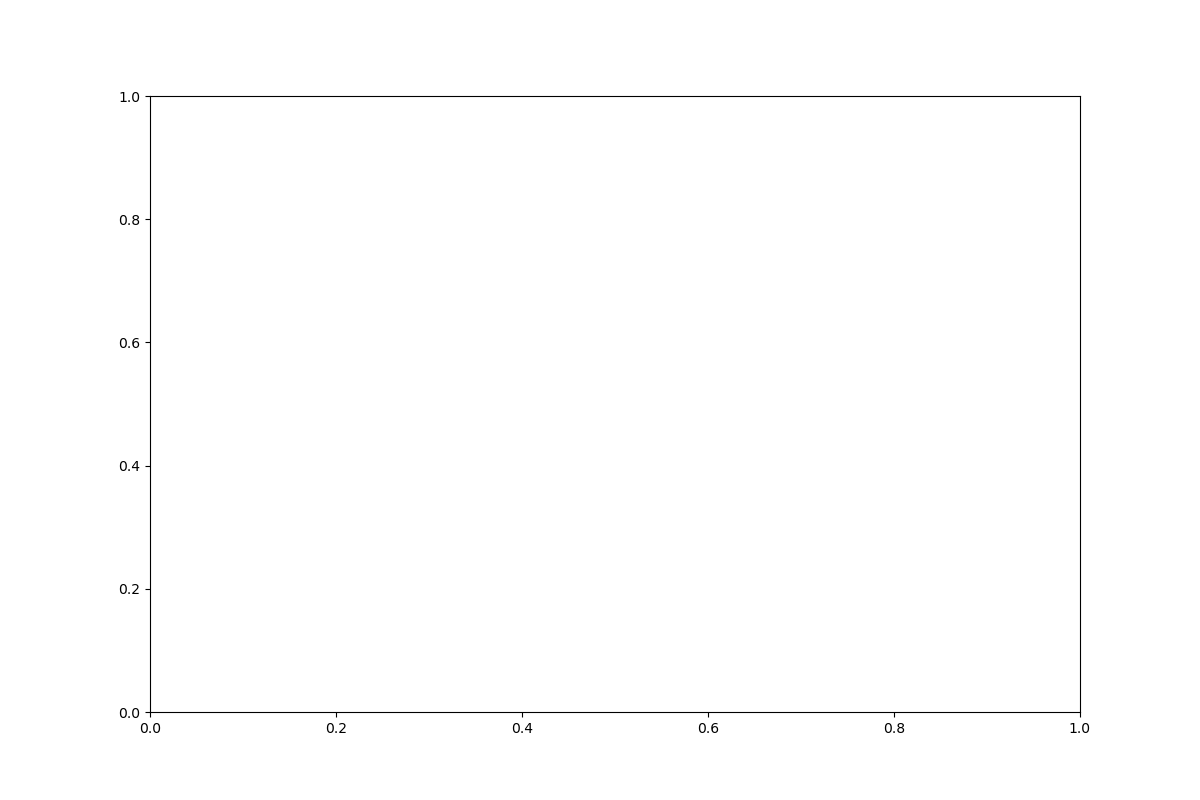

In [7]:
# display interactive map

# BlueMarble_Bathymetry base map
# newbasemap = {
#                'url':'https://gibs.earthdata.nasa.gov/wmts/epsg3857/best/BlueMarble_ShadedRelief_Bathymetry/default/GoogleMapsCompatible_Level8/{z}/{y}/{x}.jpeg',
#                'max_zoom': 11,
#                'attribution': '\nImagery provided by GIBS, operated by the NASA/GSFC/<a href="https://earthdata.nasa.gov">ESDIS</a> with funding provided by NASA/HQ\n',
#                'name': 'NASAGIBS.BlueMarble_Bathymetry'
#             }

# ESRI basemap
newbasemap = {
                'url':'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}.jpg',
                'attribution': '\nImagery provided by ESRI\n',
                'name': 'ESRI basemap'
             }

# converted to a layer to add max_native_zoom field, but used as a basemap
newbasemaplayer = ipyleaflet.basemap_to_tiles(newbasemap)

cubelayer = ipyleaflet.GeoJSON(
                                data=cube_json,
                                name='ITS_LIVE datacube coverage',
                                style={
                                    'opacity': 0.8, 'fillOpacity': 0.2, 'weight': 1, 'color':'red', 'cursor': 'crosshair'
                                },
#                                 default_style = {'cursor': 'crosshair'},
                                hover_style={
                                    'color': 'white', 'dashArray': '0', 'fillOpacity': 0.5,
                                },
                              )


center = [64.20, -49.43]

its_live_map = ipyleaflet.Map(
                                basemap=newbasemaplayer,
                                center=center,
                                zoom=3,
                                layout=ipywidgets.widgets.Layout(
                                            width='100%',   # Set Width of the map, examples: "100%", "5em", "300px"
                                            height='900px',  # Set height of the map
                                )
                            )

vellayer = {'url': 'https://glacierflow.nyc3.digitaloceanspaces.com/webmaps/vel_map/{z}/{x}/{y}.png',
            'attribution': '\nITS_LIVE velocity mosaic (<a href="https://its-live.jpl.nasa.gov">ITS_LIVE</a>) with funding provided by NASA MEaSUREs.\n',
            'name': 'ITS_LIVE velocity'}

velLayer = ipyleaflet.basemap_to_tiles(vellayer,opacity=0.75,max_native_zoom=10,)
its_live_map.add_layer(velLayer)
its_live_map.add_layer(cubelayer)
its_live_map.double_click_zoom = False

# set up "layer group" for point markers and add it to map as layer - it is a container for the markers
picked_points_layer_group = ipyleaflet.LayerGroup(layers=[], name='picked points')
its_live_map.add_layer(picked_points_layer_group)
its_live_map.add_control(ipyleaflet.MeasureControl(position='topleft', active_color = 'orange', primary_length_unit = 'kilometers'))
its_live_map.add_control(ipyleaflet.FullScreenControl())
its_live_map.add_control(ipyleaflet.LayersControl())
its_live_map.add_control(ipyleaflet.ScaleControl(position='bottomleft'))


# zoom_slider = ipywidgets.IntSlider(description='Zoom level:', min=0, max=20, value=3)
#ipywidgets.jslink((zoom_slider, 'value'), (its_live_map, 'zoom'))
#widget_control1 = ipyleaflet.WidgetControl(widget=zoom_slider, position='topright')
#its_live_map.add_control(widget_control1)


# set map default cursor to crosshair - still a hand until first zoom for some reason
its_live_map.default_style = {'cursor': 'crosshair'}
# its_live_map.default_style = {'cursor': 'default'} # to reset


# set up click to place new markers to include in time series plot - markers may be moved after they are placed
#
# ISSUE: .on_click registering twice in safari resulting in 2 markers - this prevents that by recognizing that the location of the two clicks is the same before registering
# WILL FAIL if two clicks are not generated with same coordinates (if this happens, world is good, get rid of duplicate on_click requirement)
# may need fix to detect lack of issue on other platforms?
#
icon_color_index=0
last_click = None
#
# decorator captures function text output in widget
@outwdgt.capture(clear_output=False,wait=True)
def handle_mapclick(**kwargs):
    global last_click,icon_color_index
#     if('move' not in kwargs.get('type')):
#         print(kwargs)
    if kwargs.get('type') == 'click':
        # NOTE this is the work around for the double click issue discussed above!
        # Only acknoledge the click when it is registered the second time at the same place!
        if last_click and (kwargs.get('coordinates') == last_click.get('coordinates')):
            #colorstr=colornames[icon_color_index]
            # from https://stackoverflow.com/questions/23567203/leaflet-changing-marker-color
            f = plt.cm.tab10(icon_color_index)
            html_for_marker = f'<span style="background-color:rgba({f[0]*100}%, {f[1]*100}%, {f[2]*100}%, {f[3]}); width: 3rem;height: 3rem;display: block;left: -1.5rem;top: -1.5rem;position: relative;border-radius: 3rem 3rem 0;transform: rotate(45deg);border: 1px solid #FFFFFF" />'

            #html_for_marker = f'<span style="background-color: {colorstr}; width: 3rem;height: 3rem;display: block;left: -1.5rem;top: -1.5rem;position: relative;border-radius: 3rem 3rem 0;transform: rotate(45deg);border: 1px solid #FFFFFF" />'
            icon = ipyleaflet.DivIcon(html=html_for_marker, icon_anchor=[0,24],icon_size=[10,10])
            new_point = ipyleaflet.Marker(location=kwargs.get('coordinates'), icon=icon)

            # added points are tracked (color/symbol assigned) by the order they are added to the layer_group (each point/icon is a layer by itself in ipyleaflet)
            picked_points_layer_group.add_layer(new_point)
            print(f"point added {kwargs.get('coordinates')}")
            icon_color_index+=1
            #if icon_color_index>=len(colornames):
            #    icon_color_index=0
        else:
            last_click = kwargs

its_live_map.on_interaction(handle_mapclick)

# make, place and handle plot button click
@outwdgt.capture(clear_output=False,wait=True)
def make_plot_now(kwdargs):
    global picked_points_layer_group
    global plotax, color_index

    # reset plot and color index
    plotax.clear()
    plotax.set_xlabel('date')
    plotax.set_ylabel('speed (m/yr)')
    plotax.set_title(f'{datacube_to_use} ITS_LIVE ice flow speed (from S3 bucket)')
    pltfig.tight_layout()
    color_index = 0

    picked_points_latlon=[a.location for a in picked_points_layer_group.layers]
    if len(picked_points_latlon)>0:
        print(f'plotting')
        for lat,lon in picked_points_latlon:
            plotpointonfig([lon,lat],plotax,'4326')
        print('done plotting')
    else:
        print('no picked points to plot yet - pick some!')

plotbutton = ipywidgets.Button(description='Make Plot', tooltip='click to make plot')
plotbuttonwidgcntrl = ipyleaflet.WidgetControl(widget=plotbutton,position='bottomright')
its_live_map.add_control(plotbuttonwidgcntrl)
plotbutton.on_click(make_plot_now)

# make, place and handle clear points button click
@outwdgt.capture(clear_output=False,wait=True)
def clear_points(kwdargs):
    global picked_points_layer_group
    global plotax, color_index, icon_color_index
    # reset plot and color index
    plotax.clear()
    color_index = 0
    icon_color_index = 0
    picked_points_layer_group.clear_layers()
    print('all points cleared')

clearpointsbutton = ipywidgets.Button(description='Clear Points', tooltip='clear all picked points')
clearpointsbuttonwidgcntrl = ipyleaflet.WidgetControl(widget=clearpointsbutton,position='bottomright')
its_live_map.add_control(clearpointsbuttonwidgcntrl)
clearpointsbutton.on_click(clear_points)

plot_running_mean_checkbox = ipywidgets.Checkbox(
                                                value=True,
                                                description='include running mean',
                                                disabled=False,
                                                indent=False,
                                                tooltip='Plot running mean through each time series',
                                                layout=ipywidgets.Layout(width='150px')
                                                )
plot_running_mean_widgcntrl = ipyleaflet.WidgetControl(widget=plot_running_mean_checkbox,position='bottomright')
its_live_map.add_control(plot_running_mean_widgcntrl)


# add the logo
logowidget = ipyleaflet.WidgetControl(widget=imagewidget,position='topright')
its_live_map.add_control(logowidget)

# render the map
display(its_live_map)

# show text output widget that displays decorated function text
display(outwdgt)

# set up time series plot window
pltfig,plotax = plt.subplots(1,1,figsize=(12,8))
